In [121]:
import pandas as pd
import numpy as np
from itertools import chain
from collections import defaultdict
import re
import matplotlib.pyplot as plt
plt.style.use('dark_background')

Mr. Brochard **deserves praise** for these highly valuable data.  Despite 
repeated and ongoing criticism from the gallery, he understood 
taking a census, however ad hoc, yields benefits far outweighing
whatever political and statistical objections would arise.  Apart from the pure
entertainment value these results provide, his initial effort potentially opens
the door for future iterations in the vein of StackOverflow's oft cited,
and equally ad hoc, developer survey.

> *In every revolution, there's one man with a vision.* -- J. T. Kirk

**Chart percentages are solely relative indicators.**
For mutually exclusive options ("yes" versus "no"), the percentages reflect reality.
For nonexclusive options ("I run both Linux and Windows"), the numerator ("Linux")
goes up by one, but the denominator (number of voters) goes up by two, thus
underweighting the percentage.

In [122]:
df = pd.read_csv('Emacs-User-Survey-2020-clean.csv')
alias = ['datetime', 'medium', 'synopsis', 'app', 'age', 'version', 'os', 'invoke',
         'xwin', 'xtoggle', 'kit', 'bind', 'bind0', 'editor0', 'org', 'orgapp',
         'completion', 'package', 'archive', 'fave', 'theme', 'flyshit', 'tramp',
         'magit', 'project', 'shell', 'email', 'elisp', 'lang', 'lsp', 'debug',
         'core', 'melpa', 'fsf', 'forum', 'fix', 'pro', 'pain', 'onefix',
         'hear', 'demo', 'platform', 'survey', 'gfy']
column_descriptions = dict(zip(alias, df.columns.values))
df.columns = alias
df.index = pd.to_datetime(df.pop('datetime'), utc=True)
df = df.sort_index(ascending=True)


# First rule of advertising
*Attention has a very brief half-life.* 
The bulk of respondents acted shortly after the announcement.  Unless 
you're thirsty enough to announce a project *more than once*, prepare to endure
radio silence within a day of soliciting responses.

<AxesSubplot:title={'center':'Submissions timeseries'}, xlabel='datetime'>

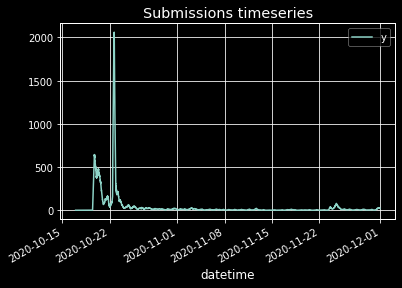

In [123]:
pd.DataFrame({'y': 1}, index=df.index).rolling('6H').sum(). \
    plot(title='Submissions timeseries')

In [124]:
def piechart(field, munging, unclassified='other', thresh=0.02, whatis=False):
    counts = defaultdict(int)
    vals = df[field].fillna("").values
    for s in vals:
        classified = False
        for k, v in munging.items():
            if re.search(k, s):
                classified = True
                counts[v] += 1
        if not classified:
            if whatis:
                print("wtf is {}".format(s))
            counts[unclassified] += 1
    for k in list(counts.keys()):
        if k != unclassified:
            if (counts[k] / len(vals)) < thresh:
                counts[unclassified] += counts[k]
                del counts[k]
    if counts[unclassified] / len(vals) < thresh:
        del counts[unclassified]
    pd.DataFrame.from_dict(counts, orient='index', columns=['counts']).plot.pie(
        y='counts', ylabel='', autopct='%1.1f%%', legend=False,
        title=column_descriptions[field], textprops={'color': "r"})


# Respondents skew young
More than half of respondents claim no more than 6 years experience.

count    7286.000000
mean        9.922591
std         9.328345
min         0.000000
25%         3.000000
50%         6.000000
75%        15.000000
max        45.000000
Name: age, dtype: float64

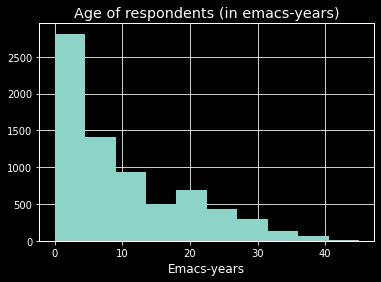

In [125]:
s = pd.to_numeric(df['age'], errors='coerce').dropna()
h = s.hist()
h.set_xlabel('Emacs-years')
h.set_title('Age of respondents (in emacs-years)')
s.describe()

# Corporations are people too
Five percent of respondents rock a version **older than 26.1.**
Presumably their choices are limited to whatever version of emacs
is bundled with the decade-old SuSE release ordinanced by hidebound IT departments.

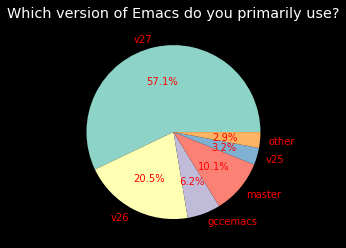

In [126]:
piechart('version', {re.compile(r'(28|master)', re.IGNORECASE): 'master',
                     re.compile(r'(gcc|native)', re.IGNORECASE): 'gccemacs',
                     re.compile(r'(remacs)', re.IGNORECASE): 'remacs',
                     re.compile(r'(27|latest)', re.IGNORECASE): 'v27',
                     re.compile(r'(26)', re.IGNORECASE): 'v26',
                     re.compile(r'(25)', re.IGNORECASE): 'v25',
                     re.compile(r'(24)', re.IGNORECASE): 'v24',
                     re.compile(r'(23)', re.IGNORECASE): 'v23',
                     re.compile(r'(22)', re.IGNORECASE): 'v22',
                     re.compile(r'(21)', re.IGNORECASE): 'v21',
                     re.compile(r'(20)', re.IGNORECASE): 'v20',
                     re.compile(r'(19)', re.IGNORECASE): 'v19',
                     re.compile(r'(whatev|stabl)', re.IGNORECASE): 'dist',
                  }, 'other')

# All your base are belong to POSIX
For Windows users, the beatings shall continue until
their customers come to their senses (which likely won't ever happen).

<AxesSubplot:title={'center':'Which OS do you primarily use Emacs on?'}>

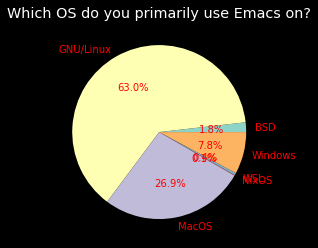

In [127]:
df.loc[df.os == 'FreeBSD', 'os'] = 'BSD'
df.loc[df.os == 'Linux', 'os'] = 'GNU/Linux'
df.loc[df.os == 'cygwin', 'os'] = 'Windows'
df.loc[df.os == 'nixOS', 'os'] = 'NixOS'
df.loc[df.os == 'Windows Subsystem for Linux', 'os'] = 'WSL'
af = df[['os']].groupby('os').size().to_frame(name='counts')
uf = af[(af['counts'] <= 1) | (af.index.str.contains(';'))]
uuf = af[~af.index.isin(uf.index.to_list())]
# age distribution of problematicists
# pd.to_numeric(df[df['os'].isin(uf.index.to_list())]['age'], errors='coerce').dropna().astype(int).values
for s in list(chain.from_iterable([re.split(r'[\s]*;[\s]*', cat)
                                   for cat in uf.index.to_list()])):
    for k, v in {re.compile(r'(gnu|(?<!for )linux)', re.IGNORECASE): 'GNU/Linux',
                 re.compile(r'(wsl|subsystem)', re.IGNORECASE): 'WSL', 
                 re.compile(r'(osx|mac)', re.IGNORECASE): 'MacOS', 
                 re.compile(r'(win)', re.IGNORECASE): 'Windows',
                 }.items():
        if re.search(k, s):
            uuf.loc[v]['counts'] += 1
uuf.plot.pie(y='counts', ylabel='', autopct='%1.1f%%', legend=False,
             textprops={'color': "r"},
             title=column_descriptions['os'])

# Uniformity: bad for pluralism, good for keybindings
It would be better for emacs devs, and world peace generally,
if this pie chart were one color.

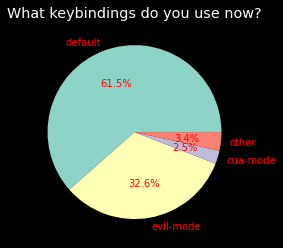

In [128]:
piechart('bind', {re.compile(r'(cua)', re.IGNORECASE): 'cua-mode',
                  re.compile(r'(custom|own|my)', re.IGNORECASE): 'custom',
                  re.compile(r'(hjkl|evil|viper|doom|spacemacs|vim)', re.IGNORECASE): 'evil-mode', 
                  re.compile(r'(xah|ergo)', re.IGNORECASE): 'xah-fly-keys',
                  re.compile(r'(god)', re.IGNORECASE): 'god-mode',
                  re.compile(r'(castle)', re.IGNORECASE): 'castlemacs',
                  re.compile(r'(default)', re.IGNORECASE): 'default',
                  })


The median evil-modalist is **seven emacs-years younger** than the median
traditionalist.

In [129]:
mask = df['bind'].str.contains("evil|doom|spacemacs|vim", case=False)
pd.to_numeric(df[~mask]['age'], errors='coerce').dropna().astype(int).median() - \
    pd.to_numeric(df[mask]['age'], errors='coerce').dropna().astype(int).median()

7.0

# The only thing necessary for the triumph of evil...
is for good men to continue teaching vi.  It's not clear whether vi's
continued popularity owes more to the evangelism of computer science departments
or the "shabby chic" of embracing 1970s computing austerity.  Many point to vi's 
universal availability, but that argument hasn't held water for me since the advent
of desktop Linux (and no one makes this argument about ed).

I am a fan of vi to be sure, and it took many years to wean myself off the clear
superiority of modal editing, but I balk at retrofitting vi's modalism to emacs.

No big surprises with previous text editors used.

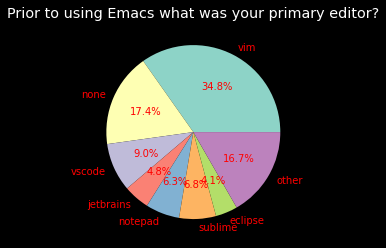

In [130]:
piechart('editor0', 
         {re.compile(r'(remember|forgot|long)', re.IGNORECASE): 'forgot',
          re.compile(r'(none|stone|^$)', re.IGNORECASE): 'none',
          re.compile(r'(kak|\bvi\b|vim|elvis|nvi)', re.IGNORECASE): 'vim', 
          re.compile(r'(bbedit)', re.IGNORECASE): 'bbedit',
          re.compile(r'(sublime)', re.IGNORECASE): 'sublime',
          re.compile(r'(eclipse)', re.IGNORECASE): 'eclipse',
          re.compile(r'(netbeans)', re.IGNORECASE): 'netbeans',
          re.compile(r'(xcode)', re.IGNORECASE): 'xcode',
          re.compile(r'(atom)', re.IGNORECASE): 'atom',
          re.compile(r'(nano|pico)', re.IGNORECASE): 'nano/pico',
          re.compile(r'(brain|pycharm|intel|idea|storm)', re.IGNORECASE): 'jetbrains',
          re.compile(r'(geany|gedit)', re.IGNORECASE): 'geany',
          re.compile(r'(pad)', re.IGNORECASE): 'notepad',
          re.compile(r'(kate)', re.IGNORECASE): 'kate',
          re.compile(r'(brief)', re.IGNORECASE): 'brief',
          re.compile(r'(\bed\b|edlin)', re.IGNORECASE): 'ed',
          re.compile(r'(vscode|visual|studio)', re.IGNORECASE): 'vscode',
          re.compile(r'(jove|emacs|teco|epsilon)', re.IGNORECASE): 'protoemacs',
          re.compile(r'(jed|joe)', re.IGNORECASE): 'jed/joe',
          re.compile(r'(textmate)', re.IGNORECASE): 'textmate',
          })


# Candor of youth
Consequent to the same observation amongst evil-modalists, **doom and spacemacs users
skew younger**, in this case by about six years.

In [131]:
mask = df['kit'].str.contains("doom|spacemacs", case=False)
pd.to_numeric(df[~mask]['age'], errors='coerce').dropna().astype(int).median() - \
    pd.to_numeric(df[mask]['age'], errors='coerce').dropna().astype(int).median()

6.0

As observed in the age plot, respondents to surveys on the whole skew younger.
One might extrapolate and claim youth correlates with greater vocalization and 
opinion sharing.  Anecdotally, doom as a preference is more
keenly felt on /r/emacs than its 1:6 user ratio, while very significant,
might suggest.  Higher posting rates among "zoomer doomers" drive greater adoption
of doom amongst new users, which is great for doom but creates some friction with
the silent majority of traditional emacs users, many of whom write packages that
are not tested under evil-mode nor many of doom's "features by fiat."

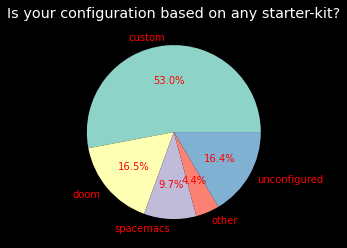

In [132]:
piechart('kit', {re.compile(r'(spacemacs)', re.IGNORECASE): 'spacemacs',
                 re.compile(r'(vanilla)', re.IGNORECASE): 'unconfigured', 
                 re.compile(r'(prelude)', re.IGNORECASE): 'prelude',
                 re.compile(r'(none|custom|emacs\.d|own)', re.IGNORECASE): 'custom',
                 re.compile(r'(doom)', re.IGNORECASE): 'doom',
                 })


No big surprises with **completion frameworks.**

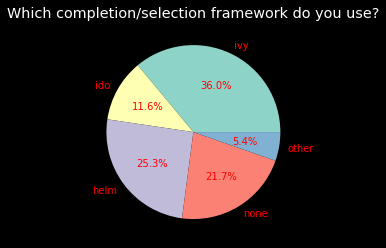

In [133]:
piechart('completion',
         {re.compile(r"(don't|none|idea|default)", re.IGNORECASE): 'none',
          re.compile(r'(selectrum)', re.IGNORECASE): 'selectrum', 
          re.compile(r'(icomplete)', re.IGNORECASE): 'icomplete',
          re.compile(r'(mpany)', re.IGNORECASE): 'company',
          re.compile(r'(\bido)', re.IGNORECASE): 'ido',
          re.compile(r'(ivy)', re.IGNORECASE): 'ivy',
          re.compile(r'(helm)', re.IGNORECASE): 'helm',
          })


As doom employs straight.el, the representation of their users is commensurate.

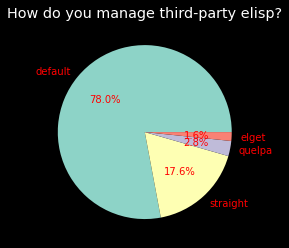

In [134]:
piechart('package',
         {re.compile(r'(straight|doom)', re.IGNORECASE): 'straight',
          re.compile(r'(leaf)', re.IGNORECASE): 'leaf',
          re.compile(r'(quelpa)', re.IGNORECASE): 'quelpa',
          re.compile(r'(el-get|elget)', re.IGNORECASE): 'elget',
          },
         'default', 0.005)


# TRAMP shines but on one side of the moon
Even amongst a self-selecting cohort of emacs enthusiasts, TRAMP
is a misspelling for about half of respondents.  Quoth one respondent:

> What is TRAMP and why do you need to SHOUT it’s [sic] name?

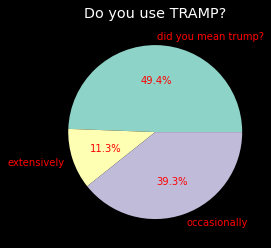

In [135]:
piechart('tramp', {re.compile(r'(extens)', re.IGNORECASE): 'extensively',
                   re.compile(r'(occas)', re.IGNORECASE): 'occasionally',
                   },
         'did you mean trump?')


# Magit nation
Shout-out to the naysh.

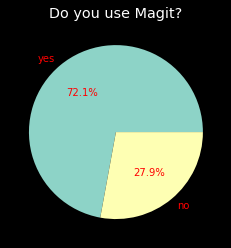

In [136]:
piechart('magit', {re.compile(r'(yes|occas|somet)', re.IGNORECASE): 'yes',
                   },
         'no')


No big surprises with **shell preferences**.

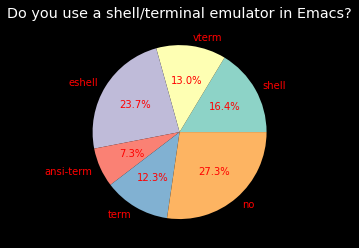

In [137]:
piechart('shell', {re.compile(r'(multi)', re.IGNORECASE): 'multi-term',
                   re.compile(r'(eshell)', re.IGNORECASE): 'eshell', 
                   re.compile(r'(ansi)', re.IGNORECASE): 'ansi-term', 
                   re.compile(r'(\bterm\b)', re.IGNORECASE): 'term',
                   re.compile(r'(\bshell\b)', re.IGNORECASE): 'shell',
                   re.compile(r'(vterm\b)', re.IGNORECASE): 'vterm',
                   },
         'no')


# Law of software envelopment
> Every program attempts to expand until it can read mail.  
> Those programs which cannot so expand are replaced by ones which can.  
> -- J. Zawinski

It is with some irony that the program that inspired Zawinski's law has gotten
much harder to configure for mail since the days of /var/spool.  Emacs's constancy
of course is both blessing and curse, although in the context of mail,
indubitably the latter.
It is not emacs's fault that email has evolved into a Rube Goldberg machine replete with
all manner of small moving parts.  The developers of Gnus and RMAIL have over the 
last two decades tried valiantly to keep up albeit with mixed results.

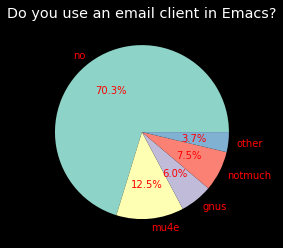

In [138]:
piechart('email', {re.compile(r'(gnus)', re.IGNORECASE): 'gnus',
                   re.compile(r"(\bno\b|don't|none|idea|default|^$)", re.IGNORECASE): 'no',
                   re.compile(r'(mu4e)', re.IGNORECASE): 'mu4e', 
                   re.compile(r'(mh-e)', re.IGNORECASE): 'mh-e', 
                   re.compile(r'(mutt)', re.IGNORECASE): 'mutt', 
                   re.compile(r'(vm)', re.IGNORECASE): 'VM', 
                   re.compile(r'(mew)', re.IGNORECASE): 'mew',
                   re.compile(r'(mutt)', re.IGNORECASE): 'mutt',
                   re.compile(r'(wanderlust)', re.IGNORECASE): 'wanderlust',
                   re.compile(r'(notmuch)', re.IGNORECASE): 'notmuch',
                   re.compile(r'(rmail)', re.IGNORECASE): 'rmail',
                   },
         'other')


Email, like one's text editor, tends to be a very sticky app, and Gnus is 
a very old program.  We'll note the median and 75th percentile of Gnus users are a
whopping 15 and 23 years respectively, compared to just 6 and 13 years for mu4e/notmuch.

In [139]:
# age distribution for gnus
mask = df['email'].str.contains("gnus", case=False).fillna(False)
pd.to_numeric(df[mask]['age'], errors='coerce').dropna().astype(int).describe()

count    451.000000
mean      15.133038
std       10.136843
min        0.000000
25%        5.000000
50%       15.000000
75%       23.000000
max       40.000000
Name: age, dtype: float64

In [140]:
# age distribution for mu4e/notmuch
mask = df['email'].str.contains("mu4e|notmuch", case=False).fillna(False)
pd.to_numeric(df[mask]['age'], errors='coerce').dropna().astype(int).describe()

count    1459.000000
mean        8.984236
std         8.379323
min         0.000000
25%         3.000000
50%         6.000000
75%        13.500000
max        42.000000
Name: age, dtype: float64

We'll also note Gnus users form a nice bimodal distribution with 
a second peak right around twenty years, or around the time of "Pterodactyl"
which stabilized Gnus for the next four years (until that time Gnus was
still a toddler subject to annual releases).

By that time though, with the advent of Web 2.0, email was being rapidly carved up by the
first imperialists of big tech (aol-netscape, hotmail, yahoo, excite, etc.) via 
http-friendly IMAP and POP protocols, leaving Gnus, RMAIL, and VM somewhat in the cold.

Text(0.5, 1.0, 'Age of Gnus users (in emacs-years)')

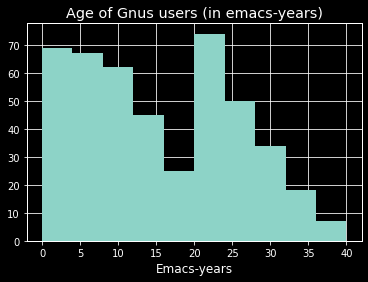

In [141]:
mask = df['email'].str.contains("gnus", case=False).fillna(False)
h = pd.to_numeric(df[mask]['age'], errors='coerce').dropna().astype(int). \
    sort_values().hist()
h.set_xlabel('Emacs-years')
h.set_title('Age of Gnus users (in emacs-years)')

Mu4e is a much more modern incarnation of emacs mail christened in 2012, and
its user distribution follows a typical pattern of quadratically increasing
adoption.  Roughly one-third of mu4e/notmuch are 3 emacs-years
or younger.

Text(0.5, 1.0, 'Age of Mu4e users (in emacs-years)')

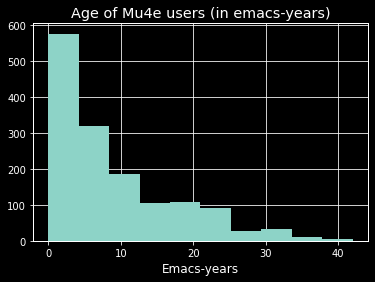

In [142]:
mask = df['email'].str.contains("mu4e|notmuch", case=False).fillna(False)
h = pd.to_numeric(df[mask]['age'], errors='coerce').dropna().astype(int). \
    sort_values().hist()
h.set_xlabel('Emacs-years')
h.set_title('Age of Mu4e users (in emacs-years)')

# More than four out of five emacs users work for a living
The rest of us write elisp.  As personal anecdata, for most of my emacs life,
I was a copy-paster.  Then about two years ago, I fell into an elisp cul-de-sac.

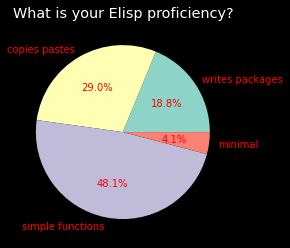

In [143]:
piechart('elisp', {re.compile(r'(simple)', re.IGNORECASE): 'simple functions',
                   re.compile(r'(package)', re.IGNORECASE): 'writes packages',
                   re.compile(r'(copy|paste)', re.IGNORECASE): 'copies pastes',
                   re.compile(r'(\bno\b|^$)', re.IGNORECASE): 'minimal',
                   })

# LSP
More than I expected.  Maybe I did this wrong.

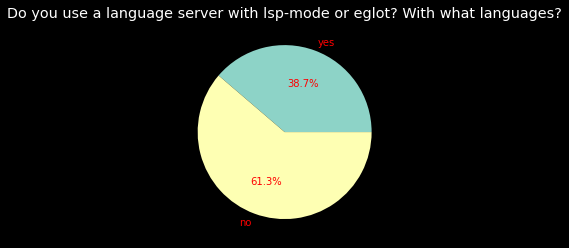

In [144]:
piechart('lsp', {re.compile(r'(yes|lsp|eglot)', re.IGNORECASE): 'yes',

                 re.compile(r"(working|current|gotten|try|tried|don't|\bno\b|\bnot\b|yet|^$)", re.IGNORECASE): 'no',
                 }, 'yes')

# Gdb in emacs used to be so nice
Time was `M-x gdb` worked flawlessly.  At some point, gud or "Grand Unified Debugger"
became the ring to rule them all, with no discernible loss of functionality.
Then some time in the oughts, 
things started to go sideways, and "realgud" attempted to make debugging great again
with limited success.  Now the latest pretender to the throne is something called
gdb/mi, with a flashy upstart called "dap-mode" nipping at its mud-caked heels, 
but at this point I'm too accustomed to running gdb outside emacs.

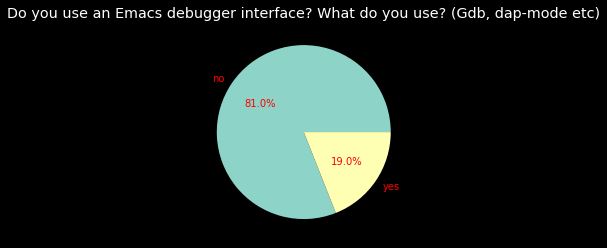

In [145]:
piechart('debug', {re.compile(r"(didn't|never|rare|awful|wish|want|like to|working|current|gotten|try|tried|don't|\bno\b|\bnot\b|yet|^$)", re.IGNORECASE): 'no',
                   }, 'yes')

# Emacs core contributors is and probably should remain small
Leaving out the small kernel of "active developers", less than five percent of
respondents profess a contribution to core.

Many users aver they would contribute to core if the curmudgeonly smtp-based method
of patch submission were replaced by http-based pull requests.
Personally, I slightly favor a
github-like forge over the current Gnus-based debbugs tracker.  I make that judgment
in light of, what was in hindsight, ESR's benificent migration of the Bazaar repo to
git in 2014, which at the time also elicited objections from the
philosopher-kings.
At the same time, I dread the deluge of crap such a new PR-based
regime would invite once the drawbridge is lowered.

Making something harder than it needs to be does ensure a certain competence.
Manual transmission cars are another example of such natural gatekeeping.  You
were more assured of a new driver's roadworthiness if she could work a clutch, 
more so than if she relied on electronic assists to parallel park.

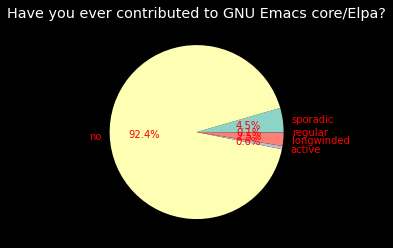

In [146]:
piechart('core', {re.compile(r'(time to time)', re.IGNORECASE): 'sporadic',
                  re.compile(r'(active)', re.IGNORECASE): 'active',
                  re.compile(r'(yes|regular)', re.IGNORECASE): 'regular',
                  re.compile(r"(didn't|never|rare|awful|wish|want|like to|working|current|gotten|try|tried|don't|\bno\b|\bnot\b|yet|^$)", re.IGNORECASE): 'no',
                  }, 'longwinded', 0.00001)

# More than five out of six respondents have jobs
The rest of us write MELPA packages.  To the chagrin of some, MELPA has
become the de facto collection point for emacs enthusiasts. Thankfully for global
productivity, most respondents have never written or contributed to MELPA.
I suspect even the MELPA maintainers would concede most of the stuff on there are
trivial pet projects of dubious utility.

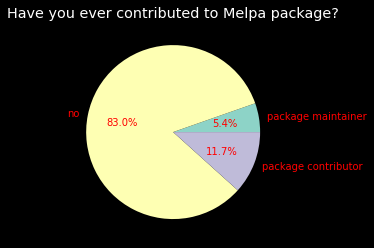

In [147]:
piechart('melpa', {re.compile(r'(maintainer)', re.IGNORECASE): 'package maintainer',
                   re.compile(r'(time to time|regular)', re.IGNORECASE): 'package contributor',
                   re.compile(r"(didn't|love|never|rare|awful|wish|want|like to|working|current|gotten|try|tried|don't|\bno\b|\bnot\b|yet|^$)", re.IGNORECASE): 'no',
                   }, 'longwinded')

# FSF Contributions
More than I expected.  Maybe I did this wrong.

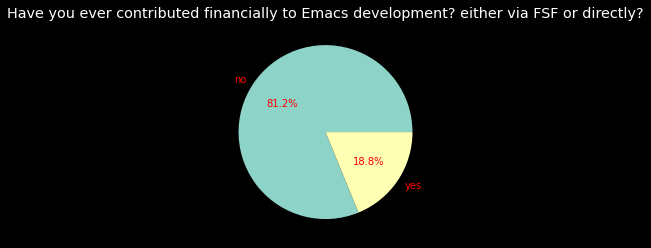

In [148]:
piechart('fsf', {re.compile(r"(didn't|never|rare|awful|wish|(love|want|like) to|working|current|gotten|try|tried|don't|\bno\b|\bnot\b|yet|^$)", re.IGNORECASE): 'no',
                 }, 'yes')

# Forums
A surprising 1,281 respondents mentioned twitter as an exposure vector.

In [149]:
sum('twitter' in s for s in df['forum'].dropna().values)

1281

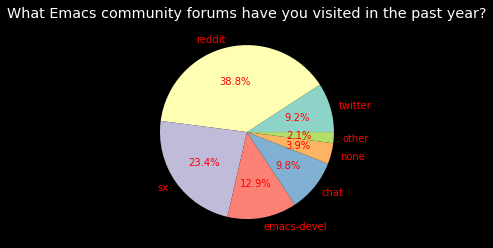

In [150]:
piechart('forum', {re.compile(r'(twitter)', re.IGNORECASE): 'twitter',
                   re.compile(r'(r/|reddit)', re.IGNORECASE): 'reddit',
                   re.compile(r'(mailing)', re.IGNORECASE): 'emacs-devel',
                   re.compile(r'(gitter|slack|erc|irc|discord|telegram)', re.IGNORECASE): 'chat',
                   re.compile(r'(hacker|lobs)', re.IGNORECASE): 'HN',
                   re.compile(r'(sx|exchan)', re.IGNORECASE): 'sx',
                   re.compile(r'(china)', re.IGNORECASE): 'emacs-china.org',
                   re.compile(r"(\?|never|none|know|haven't|didn't|don't|^$)", re.IGNORECASE): 'none',
                   }, 'other')

# Org-mode
Four out of five respondents use org-mode, some religiously so.

<AxesSubplot:ylabel='counts'>

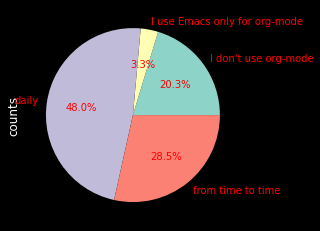

In [151]:
af = df[['org']].groupby('org').size().to_frame(name='counts')
uf = af[(af['counts'] <= 1) | (af.index.str.contains(';'))]
uuf = af[~af.index.isin(uf.index)]
uuf.plot.pie(y='counts', autopct='%1.1f%%', legend=False, textprops={'color': "r"})

Difference of 8 years between the median **non-org** user and **only-org** user.

In [152]:
mask0 = df['org'].str.contains("don't", case=False)
mask1 = df['org'].str.contains("only", case=False)
pd.to_numeric(df[mask0]['age'], errors='coerce').dropna().astype(int).median() - \
    pd.to_numeric(df[mask1]['age'], errors='coerce').dropna().astype(int).median()    

8.0

The **only-org** user is a rather curious breed.  Who are they?

In [154]:
mask = df['org'].str.contains("only", case=False)
indices = np.where(df.index.isin(df[mask]['orgapp'].str.len().nlargest(3).index))
df.iloc[indices]['orgapp'].dropna().to_list()

["Basically, org-mode runs my live. Purposes include:\n+ Note taking\n+ TODO list\n+ Agenda and time traking\n+ Document writing (which will then be exported to latex or beamer)\n+ Writing emails\n\nI don't write code (other than elisp and some autoHotKey), so I don't use any of the programming modes",
 "I started using org-mode as a todo list/task manager when I was finishing my undergraduate studies. I have recently fallen out of practice with this method of task management because many of my tasks now do not take place on a computer. I have begun to use org-mode to journal changes made to each of my PC's and for creative writing.",
 'Capturing tasks and planning work.  Capturing and storing bookmarks and things to read later.  Keeping a daily journal with org-journal.  Tracking habits with org-habit. Managing a research bibliography and taking notes on papers/books with org-ref, org-noter, and helm-bibtex.  Authoring LaTeX documents.  As a development environment with org-babel and 

# What is the one thing you would like Emacs to do differently?
> Make it open within a year of me typing emacs in the shell -- Anon.

The responses largely cluster around the old standby's of speed, multithreading,
more modern defaults, and long lines support.

Modulo the long lines issue, I generally don't understand the "emacs is slow"
criticism.  Relative to what?  Most popular editors are in many contexts slower
and consume far
more resources.  It's also unfair to compare emacs to a terminal-only beast 
like vi as emacs is an X application whose extreme versatility can for example render arbitrary glyphs in arbitrary
directions (left to right English versus right to left Arabic).

Human notions of speed are rather non-intuitive.  It's 
well known amongst performance drivers that feeling fast is often not being fast.

Occasionally someone will clamor for gpu-aware rendering, and I have to wonder what
it means to be productive.

#### This document was written in [EIN](https://github.com/millejoh/emacs-ipython-notebook).